# 🎮 Deep RL Final Project — MiniGrid Environments

## Overview
In this project, you will train deep RL agents on two MiniGrid environments. You must implement the core algorithms yourself using concepts from class.

**Read first:** Follow the instructions in the accompanying PDF. This notebook defines the environment APIs and where you may edit.

## Learning objectives
- Implement deep RL from scratch.
- Design observation preprocessing and reward shaping.
- Evaluate performance with clear metrics and plots.
- Communicate results in a concise report.

## 🌍 The Two Environments
| Environment | Description | Actions | Goal |
|-------------|-------------|---------|------|
| **`SimpleGridEnv`** | 8×8 empty room | 3 (Left, Right, Forward) | Navigate to the green goal square |
| **`KeyDoorBallEnv`** | Two rooms with locked door | 5 (Left, Right, Forward, Pickup, Toggle) | Get key → Open door → Pick up ball → Reach goal |

## ✅ What You CAN Modify
- **Preprocessing** — Implement your own observation preprocessing function.
- **Reward shaping** — Modify rewards in each `step()` method (see `# TODO`).
- **Observation space** — Update `self.observation_space` to match preprocessing output.

## ❌ What You CANNOT Modify
- Grid layout and generation logic.
- Action spaces or termination conditions.
- Environment mechanics (door/key/ball rules).
- **No external RL libraries** for the core algorithm (you may use PyTorch/TensorFlow).

## 📦 Deliverables & Submission
**Submit:** (1) this notebook with your full code and outputs, and (2) a report formatted **as specified in the instructions PDF**.

## 🧪 Reproducibility checklist
- Set random seeds for Python, NumPy, and your DL framework.
- Document hyperparameters.

## 🧾 Academic integrity
- You may discuss ideas, but code and write-up must be your own.
- Cite any external resources (blog posts, papers, code snippets).
---

# Setup

## Installs and Imports

### Installs (run once if needed)

In [182]:
# TODO: Restore for Colab
# %%capture
# !sudo apt-get update
# !sudo apt-get install -y xvfb ffmpeg freeglut3-dev
# !pip install imageio
# !pip install pyvirtualdisplay
# !pip install gymnasium
# !pip install minigrid
# !pip install pygame

### Imports

In [183]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random
import platform
import os

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML

# TODO: Restore this import when moving to Colab
# import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Lava, Wall, Ball
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# 6. PyTorch Imports (for Deep RL)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# --- Platform-specific setup ---
IS_COLAB = platform.system() == "Linux" and os.path.exists("/content")

# Create outputs directory for local development
if not IS_COLAB:
    os.makedirs("outputs", exist_ok=True)

Using device: cpu


### Display utils
The cell below contains the video display configuration. No need to make changes here.

In [184]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)

def embed_gif(filename):
    """Embeds a GIF file in the notebook (for macOS/local without ffmpeg)."""
    with open(filename, 'rb') as f:
        gif_data = f.read()
    b64 = base64.b64encode(gif_data).decode()
    return IPython.display.HTML(f'<img src="data:image/gif;base64,{b64}" width="640">')

def embed_video(filename):
    """Embeds video or GIF based on file extension."""
    if filename.endswith('.gif'):
        return embed_gif(filename)
    else:
        return embed_mp4(filename)

# TODO: Restore this block when moving to Colab
# ----- COLAB ONLY: Virtual display setup -----
# import pyvirtualdisplay
# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
# ----- END COLAB ONLY -----

# macOS/local: No virtual display needed

# Environments

> ⚠️ **Important**
>
> The two environments below are **fixed**—do not modify grid layout, action spaces, or termination conditions.
>
> **You may modify only:**
> 1. **Observation space** — set `self.observation_space` to match your preprocessing output (see `# TODO`).
> 2. **Reward shaping** — edit reward logic inside `step()` (see `# TODO`).
>
> Look for the clearly marked sections in each environment class.

In [185]:
# =============================================================================
# ENVIRONMENT 1: SIMPLE GRID (Empty Room)
# =============================================================================
class SimpleGridEnv(BaseMiniGridEnv):
    """
    A simple grid environment with no obstacles inside, just outer walls.
    The agent and goal positions are randomized at each reset.

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        preprocess=None,
        **kwargs,
    ):

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)


        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        # Updated to match pre_process output: (84, 84, 1), float32, [0, 1]
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(84, 84, 1),
            dtype=np.float32
        )
        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # Preprocessing function for observations
        self.preprocess = preprocess if preprocess is not None else lambda x: x
        self.walls_init = []
        # Default goal and agent starting position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0


    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])
        # 2. Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)
        # 3. Return the preprocessed observation
        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Procedurally generates the grid layout: walls, goal, and agent."""
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

        self.mission = "grand mission"

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Standard step function.

        Current reward scheme (sparse):
            - +1.0 when reaching the goal (terminated=True)
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        obs, reward, terminated, truncated, info = super().step(action)

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

In [186]:
# =============================================================================
# ENVIRONMENT 2: KEY-DOOR WITH BALL PICKUP
# =============================================================================
class KeyDoorBallEnv(BaseMiniGridEnv):
    """
    Grid environment with two rooms separated by a locked door.

    Task sequence:
        1. Pick up key -> 2. Unlock door -> 3. Pick up ball -> 4. Reach goal

    Actions:
        0: Turn Left
        1: Turn Right
        2: Move Forward
        3: Pick Up
        4: Toggle (open/close door)
    """
    def __init__(
        self,
        size=10,
        max_steps=1000,
        render_mode="rgb_array",
        partition_col=3,
        require_ball_pickup=True,
        preprocess=None,
        **kwargs,
    ):
        self.agent_start_pos = (1, 1)
        self.agent_start_dir = 0
        self.partition_col = partition_col
        self.walls_init = []
        self.inventory = []
        self.require_ball_pickup = require_ball_pickup
        self.preprocess = preprocess if preprocess is not None else lambda x: x

        mission_space = MissionSpace(mission_func=self._gen_mission)
        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            highlight=False,
            **kwargs,
        )

        # 5 actions: left, right, forward, pickup, toggle
        self.action_space = spaces.Discrete(5)

        # ╔═════════════════════════════════════════════════════════════════════╗
        # ║  ✅ STUDENT TODO: Update observation_space to match preprocessing   ║
        # ╚═════════════════════════════════════════════════════════════════════╝
        # Updated to match pre_process output: (84, 84, 1), float32, [0, 1]
        self.observation_space = spaces.Box(
            low=0.0,
            high=1.0,
            shape=(84, 84, 1),
            dtype=np.float32
        )
        # ╔═════════════════════════════════════════════════════════════════════╝
        # ║                     END OF EDITABLE SECTION                         ║
        # ╚═════════════════════════════════════════════════════════════════════╝

        # State tracking for reward shaping (you can use these in your reward logic)
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: Core environment methods below                       ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    @staticmethod
    def _gen_mission():
        return "Pick up the key to open the door, pick up the ball, then reach the goal"

    def _get_obs(self, obs=None):
        """Returns the current observation after applying preprocessing."""
        obs = self.get_frame(highlight=False, tile_size=32)
        return self.preprocess(obs)

    def reset(self, *, seed=None, options=None):
        # Reset state tracking
        self.prev_key = False
        self.prev_door = False
        self.prev_ball = False
        self.inventory = []

        # Call parent reset, which internally calls _gen_grid()
        obs, info = super().reset(seed=seed, options=options)

        return self._get_obs(obs), info

    def _gen_grid(self, width, height):
        """Generate grid: walls, partition, door, key, ball, goal, agent."""
        # Grid with outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # Partition wall
        self.walls_init = [(self.partition_col, i) for i in range(height)]
        for col, row in self.walls_init:
            if 0 <= col < width and 0 <= row < height:
                self.grid.set(col, row, Wall())

        # Key in left room
        self.key_pos = (
            random.choice(range(1, self.partition_col)),
            random.choice(range(2, height - 1))
        )
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # Door in partition
        door_y = random.choice(range(1, height - 1))
        self.door_pos = (self.partition_col, door_y)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Goal
        self.goal_pos = (8, 8)
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Ball in right room (if required)
        if self.require_ball_pickup:
            right_x = range(self.partition_col + 2, width - 2)
            right_y = range(1, height - 1)
            while True:
                ball_x = random.choice(list(right_x))
                ball_y = random.choice(list(right_y))
                self.ball_pos = (ball_x, ball_y)
                if self.ball_pos != self.goal_pos:
                    break

            self.grid.set(ball_x, ball_y, Ball(COLOR_NAMES[1]))

        # Agent
        self.agent_pos = self.agent_start_pos
        self.agent_dir = self.agent_start_dir

    def try_pickup_ball(self):
        """Pick up ball in front and add to inventory."""
        obj = self.grid.get(self.front_pos[0], self.front_pos[1])
        if isinstance(obj, Ball):
            self.grid.set(self.front_pos[0], self.front_pos[1], None)
            self.inventory.append(obj)

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ✅ STUDENT TODO: Modify reward shaping below                           ║
    # ╚═════════════════════════════════════════════════════════════════════════╝
    def step(self, action):
        """
        Step function with sparse reward.

        Available helper methods for reward shaping:
            - self.is_carrying_key()  : Returns True if agent has the key
            - self.is_carrying_ball() : Returns True if agent has the ball
            - self.is_door_open()     : Returns True if door is open
            - self.prev_key           : Key status before this step
            - self.prev_door          : Door status before this step
            - self.prev_ball          : Ball status before this step

        Current reward scheme (sparse):
            - +1.0 for reaching goal with ball
            - 0.0 otherwise

        💡 You can add reward shaping here
        """
        # Map action 4 to toggle (internal MiniGrid uses 5 for toggle)
        if action == 4:
            action = 5

        # Track previous state for reward shaping
        self.prev_key = self.is_carrying_key()
        self.prev_door = self.is_door_open()
        self.prev_ball = self.is_carrying_ball()

        # Handle ball pickup
        if action == 3:
            self.try_pickup_ball()

        # Standard step
        obs, reward, terminated, truncated, info = super().step(action)

        # Goal only counts if ball is picked up (when required)
        terminated = terminated and (not self.require_ball_pickup or self.is_carrying_ball())

        # ----- REWARD SHAPING: EDIT BELOW THIS LINE -----
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        # ----- REWARD SHAPING: EDIT ABOVE THIS LINE -----

        return self._get_obs(obs), reward, terminated, truncated, info
    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║                     END OF EDITABLE SECTION                             ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    # ╔═════════════════════════════════════════════════════════════════════════╗
    # ║  ⛔ DO NOT MODIFY: State getter methods (use these in reward shaping)   ║
    # ╚═════════════════════════════════════════════════════════════════════════╝

    def is_carrying_key(self):
        """Check if agent has key (in hand or inventory)."""
        key_in_hand = self.carrying and isinstance(self.carrying, Key)
        key_in_inventory = any(isinstance(item, Key) for item in self.inventory)
        return key_in_hand or key_in_inventory

    def is_carrying_ball(self):
        """Check if agent has ball (in hand or inventory)."""
        ball_in_hand = self.carrying and isinstance(self.carrying, Ball)
        ball_in_inventory = any(isinstance(item, Ball) for item in self.inventory)
        return ball_in_hand or ball_in_inventory

    def is_door_open(self):
        """Returns True if the door is open."""
        if hasattr(self, 'env_door'):
            return self.env_door.is_open
        return False

# Preprocessing Method

> 💡 **Student task:** Implement your own preprocessing function below.
>
> Your preprocessing function should:
> 1. Take a raw RGB image (320×320×3) as input.
> 2. Return a processed observation that **exactly matches** your `observation_space` (shape, dtype, value range).
>
> Common preprocessing techniques:
> - Crop edges to remove borders
> - Convert to grayscale
> - Resize to smaller dimensions
> - Normalize pixel values
>
> **Reminder:** Update `self.observation_space` in both environment classes to match your output.

In [187]:
import cv2

# =============================================================================
# PREPROCESSING CONFIGURATION
# =============================================================================
# Standard size for Deep RL (same as Atari DQN benchmarks)
PREPROCESS_SIZE = (84, 84)

# Whether to normalize pixel values to [0, 1] range
# Set to True for neural network training (recommended)
# Set to False to keep uint8 [0, 255] range
NORMALIZE_PIXELS = True


def pre_process(img):
    """
    Preprocess raw RGB observation from the environment for Deep RL.
    
    Pipeline:
    1. Convert RGB to grayscale (reduces 3 channels to 1)
    2. Resize from 320x320 to 84x84 (reduces computation by ~14x)
    3. Normalize pixel values to [0, 1] range (helps neural network training)
    
    Input:  RGB image (320, 320, 3), dtype=uint8, values in [0, 255]
    Output: Grayscale image (84, 84, 1), dtype=float32, values in [0, 1]
    
    Why these choices:
    - Grayscale: Color is not essential for navigation; reduces input size
    - 84x84: Standard size for DRL (DQN paper), balances detail vs computation
    - Normalization: Neural networks train better with inputs in [0, 1] range
    """
    # Step 1: Convert RGB to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Step 2: Resize to smaller dimensions
    resized = cv2.resize(gray, PREPROCESS_SIZE, interpolation=cv2.INTER_AREA)
    
    # Step 3: Normalize to [0, 1] range if enabled
    if NORMALIZE_PIXELS:
        normalized = resized.astype(np.float32) / 255.0
    else:
        normalized = resized.astype(np.uint8)
    
    # Step 4: Add channel dimension (84, 84) -> (84, 84, 1)
    return np.expand_dims(normalized, axis=-1)


# Helper function to get the observation space that matches preprocessing output
def get_preprocessed_observation_space():
    """
    Returns the observation space that matches the pre_process output.
    Use this to update self.observation_space in environment classes.
    """
    if NORMALIZE_PIXELS:
        return spaces.Box(
            low=0.0,
            high=1.0,
            shape=(PREPROCESS_SIZE[0], PREPROCESS_SIZE[1], 1),
            dtype=np.float32
        )
    else:
        return spaces.Box(
            low=0,
            high=255,
            shape=(PREPROCESS_SIZE[0], PREPROCESS_SIZE[1], 1),
            dtype=np.uint8
        )

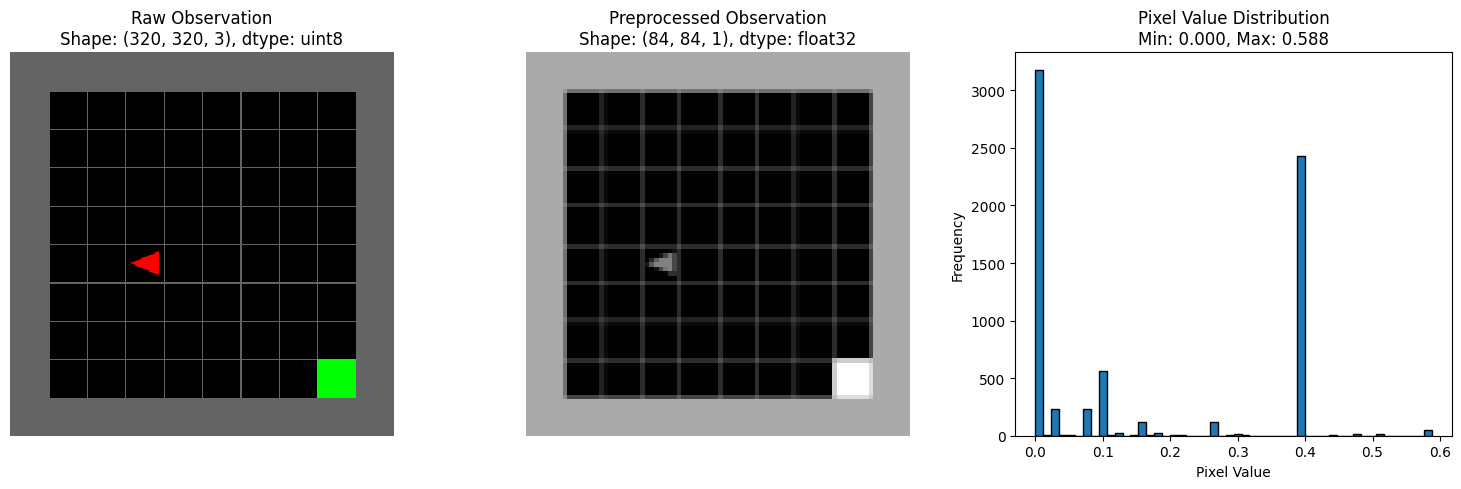


PREPROCESSING SUMMARY
Raw observation:         (320, 320, 3), dtype=uint8
Preprocessed observation: (84, 84, 1), dtype=float32
Value range:             [0.000, 0.588]
Observation space:       Box(0.0, 1.0, (84, 84, 1), float32)


In [188]:
# =============================================================================
# PREPROCESSING VERIFICATION
# =============================================================================
# Test the preprocessing function to make sure it works correctly

# Create a test environment
test_env = SimpleGridEnv(preprocess=pre_process)
test_obs, _ = test_env.reset()

# Get raw observation for comparison
raw_obs = test_env.render()

# Visualize the preprocessing
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original raw observation
axes[0].imshow(raw_obs)
axes[0].set_title(f'Raw Observation\nShape: {raw_obs.shape}, dtype: {raw_obs.dtype}')
axes[0].axis('off')

# Preprocessed observation (squeeze for display)
preprocessed_display = test_obs.squeeze()  # Remove channel dimension for imshow
axes[1].imshow(preprocessed_display, cmap='gray')
axes[1].set_title(f'Preprocessed Observation\nShape: {test_obs.shape}, dtype: {test_obs.dtype}')
axes[1].axis('off')

# Pixel value distribution
axes[2].hist(test_obs.flatten(), bins=50, edgecolor='black')
axes[2].set_title(f'Pixel Value Distribution\nMin: {test_obs.min():.3f}, Max: {test_obs.max():.3f}')
axes[2].set_xlabel('Pixel Value')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print("PREPROCESSING SUMMARY")
print(f"{'='*60}")
print(f"Raw observation:         {raw_obs.shape}, dtype={raw_obs.dtype}")
print(f"Preprocessed observation: {test_obs.shape}, dtype={test_obs.dtype}")
print(f"Value range:             [{test_obs.min():.3f}, {test_obs.max():.3f}]")
print(f"Observation space:       {test_env.observation_space}")
print(f"{'='*60}")

# Cleanup
test_env.close()

# 🔍 Environment Examples & Exploration
Run the cells below to understand each environment before implementing your solution.
Use these quick tests to verify preprocessing output shape and rendering.

## Environment 1: SimpleGridEnv (Empty Room)

**Task**: Navigate to the green goal square in an empty 8×8 room.

| Property | Value |
|----------|-------|
| Grid Size | 8×8 |
| Agent Start | Random position (1-6, 1-6) |
| Agent Direction | Random (0-3) |
| Goal Position | Random: (8,1), (1,8), or (8,8) |
| Actions | 0: Turn Left, 1: Turn Right, 2: Move Forward |
| Sparse Reward | +1.0 on reaching goal, 0.0 otherwise |

### Quick Test

=== SimpleGridEnv ===
Action space:       Discrete(3)
Number of actions:  3
Observation space:  Box(0.0, 1.0, (84, 84, 1), float32)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 1)
Agent direction:    0
Agent position:     (6, 3)
Goal position:      (8, 1)


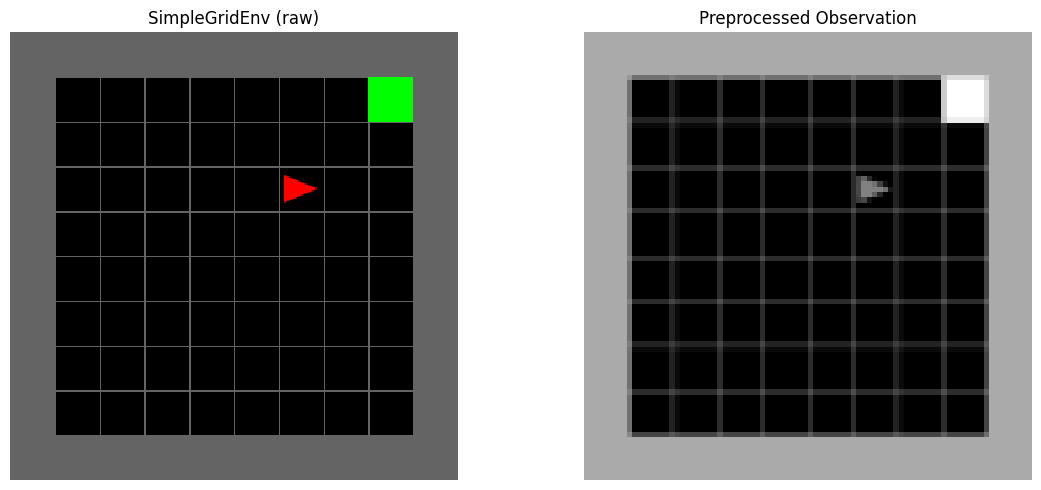

In [189]:
# Initialize environment with preprocessing
env = SimpleGridEnv(max_steps=100, preprocess=pre_process)
obs = env.reset()[0]

print("=== SimpleGridEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("SimpleGridEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

## Environment 2: KeyDoorBallEnv (Key-Door-Ball Task)

**Task**: Complete a multi-step objective: Key → Door → Ball → Goal

| Property | Value |
|----------|-------|
| Grid Size | 8×8 (two rooms) |
| Partition Wall | Column 3 |
| Key Location | Left room (random) |
| Door Location | In partition wall (random row) |
| Ball Location | Right room (random) |
| Goal Position | Fixed at (8, 8) |
| Actions | 0: Left, 1: Right, 2: Forward, 3: Pickup, 4: Toggle |

**Sequence**: Pick up key → Open door → Enter right room → Pick up ball → Reach goal

**Helper Methods** (use in reward shaping):
- `is_carrying_key()` — True if agent has the key
- `is_carrying_ball()` — True if agent has the ball
- `is_door_open()` — True if door is open

### Quick Test

=== KeyDoorBallEnv ===
Action space:       Discrete(5)
Number of actions:  5
Observation space:  Box(0.0, 1.0, (84, 84, 1), float32)  (ensure it matches preprocessing output)
Observation shape:  (84, 84, 1)
Agent direction:    0
Agent position:     (1, 1)
Goal position:      (8, 8)
Carrying key:       False
Door open:          False
Carrying ball:      False


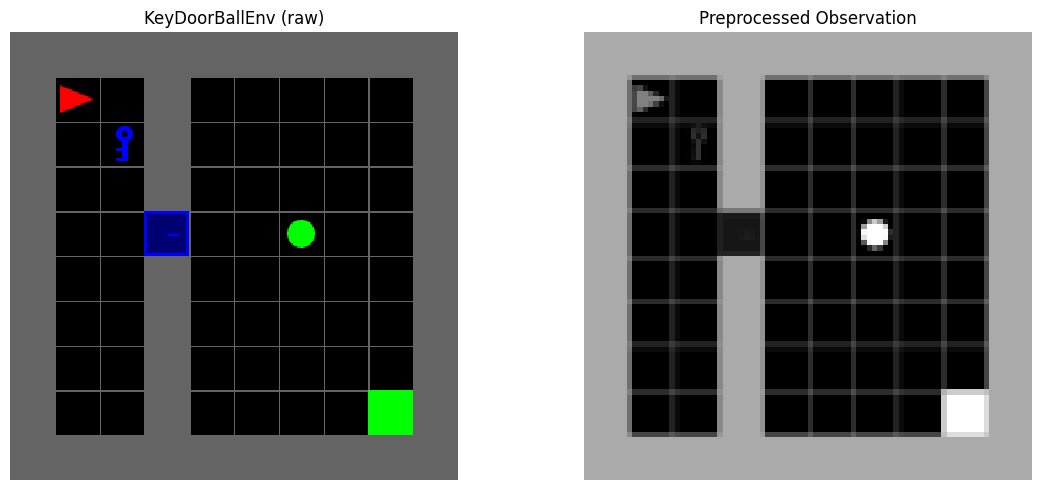

In [190]:
# Initialize environment
env = KeyDoorBallEnv(max_steps=5000, preprocess=pre_process)
obs = env.reset()[0]

print("=== KeyDoorBallEnv ===")
print(f"Action space:       {env.action_space}")
print(f"Number of actions:  {env.action_space.n}")
print(f"Observation space:  {env.observation_space}  (ensure it matches preprocessing output)")
print(f"Observation shape:  {obs.shape}")
print(f"Agent direction:    {env.agent_dir}")
print(f"Agent position:     {env.agent_pos}")
print(f"Goal position:      {env.goal_pos}")
print(f"Carrying key:       {env.is_carrying_key()}")
print(f"Door open:          {env.is_door_open()}")
print(f"Carrying ball:      {env.is_carrying_ball()}")

# Side-by-side view of raw and preprocessed observations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(env.render())
axes[0].set_title("KeyDoorBallEnv (raw)")
axes[0].axis("off")
axes[1].imshow(obs.squeeze(), cmap="gray")
axes[1].set_title("Preprocessed Observation")
axes[1].axis("off")
plt.tight_layout()
plt.show()

=== Episode Summary ===
Steps:         100
Total reward:  0.000
Terminated:    False
Truncated:     True

=== Environment Status (End of Episode) ===
Agent position:  (np.int64(1), np.int64(1))
Carrying key:    True
Door open:       True
Carrying ball:   False



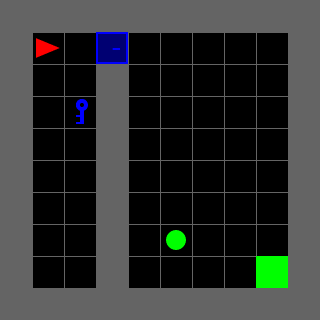

In [191]:
# Random action rollout + video
max_steps = 100
env = KeyDoorBallEnv(max_steps=max_steps, preprocess=pre_process)
num_actions = env.action_space.n
obs = env.reset()[0]

# TODO: Restore to "/content/KeyDoorBallEnv_random.mp4" when moving to Colab
# video_filename = "/content/KeyDoorBallEnv_random.mp4"
video_filename = "outputs/KeyDoorBallEnv_random.gif"  # macOS/local: GIF works without ffmpeg

with imageio.get_writer(video_filename, fps=10) as video:
    obs, _ = env.reset()
    done = False
    total_reward = 0
    for step in range(max_steps):
        action = random.randint(0, num_actions - 1)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        video.append_data(env.render())
        if done:
            break

# Print episode summary
print("=== Episode Summary ===")
print(f"Steps:         {step + 1}")
print(f"Total reward:  {total_reward:.3f}")
print(f"Terminated:    {terminated}")
print(f"Truncated:     {truncated}")
print()
print("=== Environment Status (End of Episode) ===")
print(f"Agent position:  {env.agent_pos}")
print(f"Carrying key:    {env.is_carrying_key()}")
print(f"Door open:       {env.is_door_open()}")
print(f"Carrying ball:   {env.is_carrying_ball()}")

# TODO: Restore to embed_mp4(video_filename) when moving to Colab
embed_video(video_filename)  # Works for both mp4 and gif

# Part 1: Reward Shaping

## 1.1 SimpleGridEnv Reward Shaping
Design reward shaping for the simple navigation task:
- Distance-based rewards (closer to goal = higher reward)
- Step penalty to encourage efficiency
- Consider potential-based shaping to avoid reward hacking

In [192]:
# SimpleGridEnv reward shaping implementation

## 1.2 KeyDoorBallEnv Reward Shaping
Design reward shaping for the multi-step task:
- Milestone rewards: key pickup, door open, ball pickup
- Use `is_carrying_key()`, `is_door_open()`, `is_carrying_ball()` helpers
- Use `prev_key`, `prev_door`, `prev_ball` to detect state changes

In [193]:
# KeyDoorBallEnv reward shaping implementation

# Part 2: Deep Learning Components

## 2.1 CNN Feature Extractor

Shared backbone for processing image observations. Used by both DQN and Policy Gradient networks.

| Property | Value |
|----------|-------|
| Input | Preprocessed image: `(batch, 1, 84, 84)` |
| Output | Feature vector: `(batch, 256)` |
| Architecture | 3 conv layers + 1 FC layer (DQN Nature paper style) |

In [194]:
# =============================================================================
# CNN FEATURE EXTRACTOR
# =============================================================================
# This CNN processes preprocessed images and outputs a feature vector.
# Both DQN and Policy Gradient will use this as their "backbone".

class CNNFeatureExtractor(nn.Module):
    """
    CNN that extracts features from preprocessed game images.
    
    Architecture (similar to DQN Nature paper):
    - Input: (batch, 1, 84, 84) - grayscale image
    - Conv1: 32 filters, 8x8 kernel, stride 4 → (batch, 32, 20, 20)
    - Conv2: 64 filters, 4x4 kernel, stride 2 → (batch, 64, 9, 9)
    - Conv3: 64 filters, 3x3 kernel, stride 1 → (batch, 64, 7, 7)
    - Flatten → (batch, 3136)
    - FC → (batch, 256) feature vector
    
    Output: 256-dimensional feature vector
    """
    
    def __init__(self, input_channels=1, feature_dim=256):
        """
        Args:
            input_channels: Number of input channels (1 for grayscale)
            feature_dim: Output feature vector dimension (256 recommended)
        """
        super(CNNFeatureExtractor, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Calculate flattened size after convolutions
        # Input 84x84 → conv1 → 20x20 → conv2 → 9x9 → conv3 → 7x7
        # 64 channels * 7 * 7 = 3136
        self.flat_size = 64 * 7 * 7
        
        # Fully connected layer to produce feature vector
        self.fc = nn.Linear(self.flat_size, feature_dim)
        
        # Store output dimension for other networks to use
        self.feature_dim = feature_dim
    
    def forward(self, x):
        """
        Forward pass through the CNN.
        
        Args:
            x: Input tensor of shape (batch, channels, height, width)
               or (batch, height, width, channels) - will be permuted
        
        Returns:
            Feature vector of shape (batch, feature_dim)
        """
        # Handle input shape: convert (B, H, W, C) to (B, C, H, W) if needed
        if x.dim() == 4 and x.shape[-1] in [1, 3]:  # Channels last format
            x = x.permute(0, 3, 1, 2)
        elif x.dim() == 3:  # Single image without batch: (H, W, C)
            x = x.permute(2, 0, 1).unsqueeze(0)
        
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten and pass through FC layer
        x = x.view(x.size(0), -1)  # Flatten: (batch, 3136)
        x = F.relu(self.fc(x))     # FC: (batch, 256)
        
        return x


# =============================================================================
# HELPER FUNCTION: Convert numpy observation to tensor
# =============================================================================
def obs_to_tensor(obs, device=device):
    """
    Convert a numpy observation to a PyTorch tensor ready for the CNN.
    
    Args:
        obs: Numpy array from pre_process(), shape (84, 84, 1)
        device: PyTorch device (cpu or cuda)
    
    Returns:
        Tensor of shape (1, 1, 84, 84) ready for CNN
    """
    # Convert to tensor and add batch dimension
    tensor = torch.FloatTensor(obs).to(device)
    
    # Ensure correct shape: (batch, channels, height, width)
    if tensor.dim() == 3:  # (H, W, C)
        tensor = tensor.permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
    
    return tensor


# =============================================================================
# TEST THE CNN
# =============================================================================
print("Testing CNN Feature Extractor...")
print("=" * 60)

# Create CNN
cnn = CNNFeatureExtractor(input_channels=1, feature_dim=256).to(device)

# Create dummy input matching our preprocessing output
dummy_input = torch.randn(1, 1, 84, 84).to(device)

# Forward pass
with torch.no_grad():
    features = cnn(dummy_input)

print(f"CNN Architecture:")
print(f"  Input shape:   (batch, 1, 84, 84)")
print(f"  Output shape:  {tuple(features.shape)}")
print(f"  Feature dim:   {cnn.feature_dim}")
print(f"  Total params:  {sum(p.numel() for p in cnn.parameters()):,}")
print("=" * 60)
print("✅ CNN Feature Extractor ready!")

Testing CNN Feature Extractor...
CNN Architecture:
  Input shape:   (batch, 1, 84, 84)
  Output shape:  (1, 256)
  Feature dim:   256
  Total params:  874,912
✅ CNN Feature Extractor ready!


In [195]:
# =============================================================================
# FULL PIPELINE TEST: Environment → Preprocessing → CNN
# =============================================================================
print("Testing Full Pipeline: Environment → Preprocessing → CNN")
print("=" * 60)

# Create environment with preprocessing
test_env = SimpleGridEnv(preprocess=pre_process)
obs, _ = test_env.reset()

print(f"1. Raw observation from env.render(): {test_env.render().shape}")
print(f"2. Preprocessed observation:          {obs.shape}, dtype={obs.dtype}")

# Convert to tensor
obs_tensor = obs_to_tensor(obs)
print(f"3. Tensor for CNN:                    {tuple(obs_tensor.shape)}")

# Pass through CNN
with torch.no_grad():
    features = cnn(obs_tensor)
print(f"4. CNN output features:               {tuple(features.shape)}")

print("=" * 60)
print("✅ Full pipeline working!")
print(f"   Observation → {obs.shape} → CNN → {features.shape[1]} features")

test_env.close()

Testing Full Pipeline: Environment → Preprocessing → CNN
1. Raw observation from env.render(): (320, 320, 3)
2. Preprocessed observation:          (84, 84, 1), dtype=float32
3. Tensor for CNN:                    (1, 1, 84, 84)
4. CNN output features:               (1, 256)
✅ Full pipeline working!
   Observation → (84, 84, 1) → CNN → 256 features


## 2.2 Q-Network (for DQN)
Neural network that outputs Q-values for each action:
- Input: preprocessed image
- Output: Q-value for each action

In [196]:
# Q-Network for DQN

## 2.3 Policy Network (for REINFORCE)

Neural network that outputs action probabilities for policy gradient methods.

| Property | Value |
|----------|-------|
| Input | Preprocessed image `(84, 84, 1)` |
| Output | Action probabilities (softmax) |
| Architecture | CNN backbone + FC policy head |

In [197]:
# =============================================================================
# POLICY NETWORK
# =============================================================================
# Outputs a probability distribution over actions (used by REINFORCE).

class PolicyNetwork(nn.Module):
    """
    Policy network that outputs action probabilities.
    
    Architecture:
    - CNN feature extractor (shared, 256-dim output)
    - FC layer → action probabilities (softmax)
    
    Input: Preprocessed image (84, 84, 1)
    Output: Probability for each action
    """
    
    def __init__(self, num_actions, feature_dim=256):
        """
        Args:
            num_actions: Number of possible actions (3 for SimpleGridEnv, 5 for KeyDoorBallEnv)
            feature_dim: CNN output dimension (256)
        """
        super(PolicyNetwork, self).__init__()
        
        # CNN backbone (shared feature extractor)
        self.cnn = CNNFeatureExtractor(input_channels=1, feature_dim=feature_dim)
        
        # Policy head: features → action probabilities
        self.policy_head = nn.Linear(feature_dim, num_actions)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Preprocessed observation tensor
        
        Returns:
            action_probs: Probability distribution over actions (softmax)
        """
        # Extract features using CNN
        features = self.cnn(x)
        
        # Get action logits and convert to probabilities
        logits = self.policy_head(features)
        action_probs = F.softmax(logits, dim=-1)
        
        return action_probs
    
    def select_action(self, obs):
        """
        Select an action by sampling from the policy distribution.
        
        Args:
            obs: Preprocessed observation (numpy array)
        
        Returns:
            action: Selected action (int)
            log_prob: Log probability of the selected action (for training)
        """
        # Convert observation to tensor
        obs_tensor = obs_to_tensor(obs)
        
        # Get action probabilities
        action_probs = self.forward(obs_tensor)
        
        # Sample action from the distribution
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob


# =============================================================================
# TEST POLICY NETWORK
# =============================================================================
print("Testing Policy Network...")
print("=" * 60)

# Test with SimpleGridEnv (3 actions)
policy_net = PolicyNetwork(num_actions=3).to(device)

# Create test observation
test_env = SimpleGridEnv(preprocess=pre_process)
obs, _ = test_env.reset()

# Test forward pass
obs_tensor = obs_to_tensor(obs)
with torch.no_grad():
    probs = policy_net(obs_tensor)

print(f"Input shape:  {obs.shape}")
print(f"Output probs: {probs.squeeze().cpu().numpy()}")
print(f"Sum of probs: {probs.sum().item():.4f} (should be 1.0)")

# Test action selection
action, log_prob = policy_net.select_action(obs)
print(f"Selected action: {action}")
print(f"Log probability: {log_prob.item():.4f}")

print("=" * 60)
print("✅ Policy Network ready!")

test_env.close()

Testing Policy Network...
Input shape:  (84, 84, 1)
Output probs: [0.33211166 0.32828063 0.33960775]
Sum of probs: 1.0000 (should be 1.0)
Selected action: 2
Log probability: -1.0800
✅ Policy Network ready!


# Part 3: Reinforcement Learning Components

## 3.1 Replay Buffer
Experience replay buffer for DQN:
- Store transitions (state, action, reward, next_state, done)
- Sample random batches for training

In [198]:
# Replay Buffer

## 3.2 Exploration Strategy
Epsilon-greedy exploration with decay:
- Start with high exploration (epsilon ≈ 1.0)
- Gradually decrease to low exploration (epsilon ≈ 0.01)
- Balance exploration vs exploitation

In [199]:
# Epsilon-Greedy Exploration

## 3.3 Target Network Utilities
Utilities for managing the target network in DQN:
- Hard update: copy weights periodically
- Soft update: gradual weight blending (optional)

In [200]:
# Target Network Update Utilities

# Part 4: Training Utilities

## 4.1 Metrics Logger
Track and visualize training progress:
- Episode rewards and lengths
- Loss curves
- Moving averages for smoothing

In [201]:
# Metrics Logger

## 4.2 Video Recording
Record agent behavior during and after training:
- Capture frames during rollouts
- Save as GIF/MP4 for visualization

In [202]:
# Video Recording Utility

## 4.3 Evaluation Function
Evaluate trained agent performance:
- Run 100 episodes without exploration
- Compute average steps and rewards
- Required metric for the assignment

In [203]:
# Evaluation Function

# Part 5: DQN Algorithm

## 5.1 DQN Agent
Implement the DQN agent class:
- Q-network and target network
- Action selection (epsilon-greedy)
- Learning step (batch update)

In [204]:
# DQN Agent Class

## 5.2 DQN Training Loop
Training loop for DQN:
- Collect experiences
- Store in replay buffer
- Sample batches and update Q-network
- Periodically update target network

In [205]:
# DQN Training Loop

# Part 6: Policy Gradient (REINFORCE)

REINFORCE is a Monte Carlo policy gradient method that updates the policy after each complete episode.

**Algorithm:**
1. Collect full episode trajectory using current policy
2. Compute discounted returns G_t for each timestep
3. Update policy: θ ← θ + α ∇log π(a|s) · G_t

## 6.1 REINFORCE Agent

| Component | Description |
|-----------|-------------|
| Policy Network | Neural network outputting action probabilities |
| Episode Storage | Stores log_probs and rewards during episode |
| Return Computation | Calculates discounted, normalized returns |
| Policy Update | Gradient ascent on expected return |

In [206]:
# =============================================================================
# REINFORCE AGENT
# =============================================================================

class REINFORCEAgent:
    """
    REINFORCE (Monte Carlo Policy Gradient) Agent.
    
    Algorithm:
    1. Collect full episode using current policy
    2. Compute discounted returns for each step
    3. Update policy to increase probability of good actions
    """
    
    def __init__(self, num_actions, lr=0.001, gamma=0.99):
        """
        Args:
            num_actions: Number of possible actions
            lr: Learning rate
            gamma: Discount factor for future rewards
        """
        self.gamma = gamma
        self.num_actions = num_actions
        
        # Policy network
        self.policy = PolicyNetwork(num_actions).to(device)
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # Episode storage
        self.log_probs = []  # Log probabilities of actions taken
        self.rewards = []    # Rewards received
    
    def select_action(self, obs):
        """
        Select action using the policy network.
        
        Args:
            obs: Preprocessed observation
        
        Returns:
            action: Selected action (int)
        """
        action, log_prob = self.policy.select_action(obs)
        self.log_probs.append(log_prob)
        return action
    
    def store_reward(self, reward):
        """Store reward for the current step."""
        self.rewards.append(reward)
    
    def compute_returns(self):
        """
        Compute discounted returns for each step.
        
        Returns:
            returns: List of discounted returns (normalized)
        """
        returns = []
        G = 0
        
        # Calculate returns backwards (from end of episode)
        for reward in reversed(self.rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        
        # Convert to tensor and normalize
        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        
        # Normalize returns (helps with training stability)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        return returns
    
    def update(self):
        """
        Update policy using REINFORCE algorithm.
        
        Returns:
            loss: Policy loss value (for logging)
        """
        # Compute discounted returns
        returns = self.compute_returns()
        
        # Calculate policy loss
        # Loss = -sum(log_prob * return) 
        # (negative because we want to maximize expected return)
        policy_loss = []
        for log_prob, G in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * G)
        
        policy_loss = torch.stack(policy_loss).sum()
        
        # Update policy
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # Clear episode storage
        loss_value = policy_loss.item()
        self.clear_episode()
        
        return loss_value
    
    def clear_episode(self):
        """Clear stored episode data."""
        self.log_probs = []
        self.rewards = []


# =============================================================================
# TEST REINFORCE AGENT
# =============================================================================
print("Testing REINFORCE Agent...")
print("=" * 60)

# Create agent for SimpleGridEnv (3 actions)
agent = REINFORCEAgent(num_actions=3, lr=0.001, gamma=0.99)

# Run a short test episode
test_env = SimpleGridEnv(preprocess=pre_process)
obs, _ = test_env.reset()

total_reward = 0
for step in range(10):  # Just 10 steps for testing
    action = agent.select_action(obs)
    obs, reward, terminated, truncated, _ = test_env.step(action)
    agent.store_reward(reward)
    total_reward += reward
    if terminated or truncated:
        break

# Test update
loss = agent.update()

print(f"Test episode: {step + 1} steps, reward: {total_reward:.2f}")
print(f"Policy loss: {loss:.4f}")
print("=" * 60)
print("✅ REINFORCE Agent ready!")

test_env.close()

Testing REINFORCE Agent...
Test episode: 10 steps, reward: 0.00
Policy loss: 0.0000
✅ REINFORCE Agent ready!


## 6.2 REINFORCE Training Loop

Main training function and visualization utilities.

| Function | Purpose |
|----------|---------|
| `train_reinforce()` | Train agent on environment, returns history |
| `plot_training_history()` | Visualize rewards, steps, and loss curves |

In [207]:
# =============================================================================
# REINFORCE TRAINING LOOP
# =============================================================================

def train_reinforce(env_class, num_episodes=1000, max_steps=200, lr=0.001, gamma=0.99,
                    print_every=100, render_every=None):
    """
    Train a REINFORCE agent on the given environment.
    
    Args:
        env_class: Environment class (SimpleGridEnv or KeyDoorBallEnv)
        num_episodes: Total episodes to train
        max_steps: Maximum steps per episode
        lr: Learning rate
        gamma: Discount factor
        print_every: Print progress every N episodes
        render_every: Save video every N episodes (None = no video)
    
    Returns:
        agent: Trained agent
        history: Dictionary with training metrics
    """
    # Create environment
    env = env_class(preprocess=pre_process, max_steps=max_steps)
    num_actions = env.action_space.n
    
    # Create agent
    agent = REINFORCEAgent(num_actions=num_actions, lr=lr, gamma=gamma)
    
    # Training history
    history = {
        'episode_rewards': [],
        'episode_steps': [],
        'losses': [],
        'running_reward': 0
    }
    
    print(f"Training REINFORCE on {env_class.__name__}")
    print(f"Episodes: {num_episodes}, Max steps: {max_steps}")
    print(f"Learning rate: {lr}, Gamma: {gamma}")
    print("=" * 60)
    
    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        
        # Collect episode
        for step in range(max_steps):
            action = agent.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            agent.store_reward(reward)
            episode_reward += reward
            
            if terminated or truncated:
                break
        
        # Update policy
        loss = agent.update()
        
        # Store history
        history['episode_rewards'].append(episode_reward)
        history['episode_steps'].append(step + 1)
        history['losses'].append(loss)
        
        # Running average reward
        history['running_reward'] = 0.05 * episode_reward + 0.95 * history['running_reward']
        
        # Print progress
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(history['episode_rewards'][-print_every:])
            avg_steps = np.mean(history['episode_steps'][-print_every:])
            print(f"Episode {episode + 1:4d} | "
                  f"Avg Reward: {avg_reward:7.2f} | "
                  f"Avg Steps: {avg_steps:6.1f} | "
                  f"Running Reward: {history['running_reward']:7.2f}")
    
    print("=" * 60)
    print("Training complete!")
    
    # Final metrics
    last_100_rewards = history['episode_rewards'][-100:]
    last_100_steps = history['episode_steps'][-100:]
    print(f"Last 100 episodes - Avg Reward: {np.mean(last_100_rewards):.2f}, "
          f"Avg Steps: {np.mean(last_100_steps):.1f}")
    
    env.close()
    return agent, history


def plot_training_history(history, title="REINFORCE Training"):
    """
    Plot training metrics.
    
    Args:
        history: Dictionary from train_reinforce()
        title: Plot title
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Episode rewards
    axes[0].plot(history['episode_rewards'], alpha=0.6)
    axes[0].plot(np.convolve(history['episode_rewards'], 
                             np.ones(50)/50, mode='valid'), 
                 color='red', linewidth=2, label='Moving avg (50)')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Reward')
    axes[0].set_title('Episode Rewards')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Episode steps
    axes[1].plot(history['episode_steps'], alpha=0.6)
    axes[1].plot(np.convolve(history['episode_steps'], 
                             np.ones(50)/50, mode='valid'),
                 color='red', linewidth=2, label='Moving avg (50)')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Steps')
    axes[1].set_title('Episode Steps')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Loss
    axes[2].plot(history['losses'], alpha=0.6)
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Loss')
    axes[2].set_title('Policy Loss')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()


print("✅ Training functions ready!")
print("   - train_reinforce(env_class, num_episodes, ...)")
print("   - plot_training_history(history)")

✅ Training functions ready!
   - train_reinforce(env_class, num_episodes, ...)
   - plot_training_history(history)


# Part 7: Experiments — SimpleGridEnv

## 7.1 DQN on SimpleGridEnv
Train and evaluate DQN on the simple navigation task.

In [208]:
# DQN on SimpleGridEnv

## 7.2 REINFORCE on SimpleGridEnv
Train and evaluate REINFORCE on the simple navigation task.

In [209]:
# REINFORCE on SimpleGridEnv

## 7.3 SimpleGridEnv Results & Comparison
Compare DQN vs REINFORCE on SimpleGridEnv:
- Learning curves overlay
- Final performance metrics
- Analysis of strengths/weaknesses

In [210]:
# SimpleGridEnv comparison plots and analysis

# Part 8: Experiments — KeyDoorBallEnv

## 8.1 DQN on KeyDoorBallEnv
Train and evaluate DQN on the multi-step task.

In [211]:
# DQN on KeyDoorBallEnv

## 8.2 REINFORCE on KeyDoorBallEnv
Train and evaluate REINFORCE on the multi-step task.

In [212]:
# REINFORCE on KeyDoorBallEnv

## 8.3 KeyDoorBallEnv Results & Comparison
Compare DQN vs REINFORCE on KeyDoorBallEnv:
- Learning curves overlay
- Final performance metrics
- Analysis of strengths/weaknesses

In [213]:
# KeyDoorBallEnv comparison plots and analysis

# Part 9: Hyperparameter Studies

## 9.1 Learning Rate Study
Experiment with different learning rates and analyze impact on training.

In [214]:
# Learning Rate Study

## 9.2 Exploration (Epsilon) Study
Experiment with different epsilon decay schedules.

In [215]:
# Epsilon Study

## 9.3 Replay Buffer Size Study
Experiment with different buffer sizes (DQN only).

## 9.4 Target Network Update Frequency
Experiment with different update frequencies (DQN only).

In [216]:
# Target Network Update Frequency Study

In [217]:
# Architecture / Initialization Study

# Part 10: Conclusions

## 10.1 Summary Table
Summary of all experiment results:
| Environment | Algorithm | Avg Steps | Avg Reward | Notes |
|-------------|-----------|-----------|------------|-------|
| SimpleGridEnv | DQN | | | |
| SimpleGridEnv | REINFORCE | | | |
| KeyDoorBallEnv | DQN | | | |
| KeyDoorBallEnv | REINFORCE | | | |

## 10.2 Key Findings
Document key insights from experiments:
- Which algorithm performed better and why?
- What hyperparameters had the most impact?
- What reward shaping strategies worked best?

## 10.3 Strengths & Weaknesses
Analysis of DQN vs REINFORCE:

**DQN Strengths:**
- 

**DQN Weaknesses:**
- 

**REINFORCE Strengths:**
- 

**REINFORCE Weaknesses:**
-

## 10.4 Limitations & Future Work
Document limitations and potential improvements:
- What didn't work as expected?
- What would you try with more time/resources?